# Iteration 3

We recreated a discrete-event simulation (DES) model designed to generate patient arrivals from six different sources and simulate the activity of a 24-bed critical care unit (CCU) admitting and discharging these patients. This model intends to investigate the changes of elective surgery cancellation numbers with the increase of utilised bed counts.

## 1 Aim

The second iteration of the model managed to incorporate the arrival and length of stay distributions for Elective surgery patients, despite the missing data in the Griffith's et al's paper. To replicate the simulation further, we will use LLM prompts and manual modification to add:
* A changeover period 
* A warm-up period for the model to enable it to reach a steady state
* Perform multiple replications to obtain an idea of the model's variability. 

Additionally, we aim to assess the impact of how changing the serviced bed counts affects the model's output.


## 2 Prompt Engineering and LLM results:

Griffith's paper (section 2.4) describes that the LOS metric does not correspond to the time a hospital bed in the CCU is occupied. This is because patient length of stay needs to incorporate the changeover time needed to clean the bed and surrounding area for the next patient, and get the resources in a suitable condition for the next patient. This was difficult to recreate as UHW did not provide data on the changeover time to Griffith's et al, but suggested it took between 2-8 hours. An estimate of 5 hours was used, changing the values to the lower and upper end of this distribution. The model will be updated to include this changeover time, as it would be unrealistic for our simulation to assume a bed is immediately available after the previous patient is discharged.

### Incorporate a changeover period

### Main command
Update the es_arrivals_generator function for elective surgery patients in python 3.10 and simpy 4.0, to incorporate a changeover time within a specified distribution. All time units are in hours.

### Steps
1. Create a function to get the changeover time, using a truncated normal distribution. 
2. In the `service` method of the class `ElectivePatient`, Add a changeover time function to the LOS timeout before the service is concluded. Do not modify any other code in the service method other than incorporating the LOS timeout, adding the changeover time, freeing the bed and adding the occupancy level.
Another timeout should be added to simulate changeover time, incorporating the specified values. Return a list of bed-occupancy levels.
3. Use a random variable to model the variability in the changeover time. Please return the resulting bed occupancy due to this wait time in the output. 
4. Run the simulation. Print out patient arrival times (indicating day of week, number of weeks). Please return your code integrated into the simulation model.
5. Parameters:
- The changeover times distribution is a normal distribution with a mean of 5, and ranging between 2 and 8. 
- RUN_LENGTH = 12 * 30 * 24 (see the impact of the changeover times over the span of a year/8,640 hours)




The LLM results are documented as follows:

There was an error being returned relating to the distribution(`Exponential`, `Lognormal`) and `Patient` and `ElectivePatient` Classes not being defined in the code, so this was manually added alongside the prompt. Code was manually added so the simulation could run.

In [41]:
import simpy
import numpy as np
import itertools
from scipy.stats import lognorm, truncnorm
import math
import random

# Helper function to print out messages    
def trace(msg):
    '''
    Turning printing of events on and off.
    
    Params:
    -------
    msg: str
        string to print to screen.
    '''
    if TRACE:
        print(msg)

class Scenario:
    '''
    Parameter class for CCU simulation model inputs.
    '''
    def __init__(self):
        '''
        The init method sets up our defaults. 
        '''
        self.beds = simpy.Resource(env, capacity=N_BEDS)
        
        # Inter-arrival time (IAT) distributions for five types of patients
        self.ae_arrival_dist = Exponential(MEAN_IAT_ae, random_seed=SEEDS[0])
        self.ward_arrival_dist = Exponential(MEAN_IAT_ward, random_seed=SEEDS[1])
        self.emer_arrival_dist = Exponential(MEAN_IAT_emer, random_seed=SEEDS[2])
        self.oth_arrival_dist = Exponential(MEAN_IAT_oth, random_seed=SEEDS[3])
        self.xray_arrival_dist = Exponential(MEAN_IAT_xray, random_seed=SEEDS[4])

        # Length of stay (LOS) distributions for six types of patients
        self.ae_los_dist = Lognormal(MEAN_LOS_ae, STD_LOS_ae, random_seed=SEEDS[5])
        self.ward_los_dist = Lognormal(MEAN_LOS_ward, STD_LOS_ward, random_seed=SEEDS[6])
        self.emer_los_dist = Lognormal(MEAN_LOS_emer, STD_LOS_emer, random_seed=SEEDS[7])
        self.oth_los_dist = Lognormal(MEAN_LOS_oth, STD_LOS_oth, random_seed=SEEDS[8])
        self.xray_los_dist = Lognormal(MEAN_LOS_xray, STD_LOS_xray, random_seed=SEEDS[9])
        self.es_los_dist = Lognormal(MEAN_LOS_es, STD_LOS_es, random_seed=SEEDS[10])
        
# Custom classes for distributions
class Exponential:
    def __init__(self, mean, random_seed=None):
        self.mean = mean
        self.rng = np.random.default_rng(seed=random_seed)

    def sample(self):
        return self.rng.exponential(self.mean)

class Lognormal:
    def __init__(self, mean, std, random_seed=None):
        self.mean = mean
        self.std = std
        self.rng = np.random.default_rng(seed=random_seed)
        self.sigma = np.sqrt(np.log(1 + (std/mean)**2))
        self.scale = np.exp(np.log(mean) - 0.5*self.sigma**2)

    def sample(self):
        return self.rng.lognormal(np.log(self.scale), self.sigma)
    

# Function to generate changeover time with truncated normal distribution
def get_changeover_time(mean, min_val, max_val):
    """Generate changeover time using a truncated normal distribution."""
    while True:
        changeover_time = random.normalvariate(mean, (max_val - min_val) / 2)
        if min_val <= changeover_time <= max_val:
            return changeover_time

# Sample function for elective surgery
def sample_daily_arrival_times(mean, std, lower_bound, upper_bound, sample_size, random_seed):
    """
    Sample daily arrival times from a truncated normal distribution.
    """
    np.random.seed(random_seed)
    a, b = (lower_bound - mean) / std, (upper_bound - mean) / std
    daily_arrival_times = truncnorm.rvs(a, b, loc=mean, scale=std, size=sample_size)
    daily_arrival_times.sort()
    return daily_arrival_times

    
# Patient class
class Patient:
    def __init__(self, env, patient_id, source, los_dist):
        self.env = env
        self.patient_id = patient_id
        self.source = source
        self.los_dist = los_dist

    def service(self, ccu):
        arrive_time = self.env.now
        print(f"Patient {self.patient_id} from {self.source} arrived at {arrive_time:.2f}")

        with ccu.request() as request:
            yield request
            wait_time = self.env.now - arrive_time
            los = self.los_dist.sample()
            print(f"Patient {self.patient_id} from {self.source} waited for {wait_time:.2f} hours, LOS: {los:.2f}")
            yield self.env.timeout(los)
            print(f"Patient {self.patient_id} from {self.source} left at {self.env.now:.2f}")

# ElectivePatient class                    
class ElectivePatient(Patient):
    def __init__(self, env, patient_id, source, los_dist):
        super().__init__(env, patient_id, source, los_dist)
        self.cancelled_surgeries = []  # Track patients who cancel surgery

    # Updated service method to include changeover period
    def service(self, ccu):
        arrive_time = self.env.now
        print(f"Patient {self.patient_id} from {self.source} arrived at {arrive_time:.2f}")

        if ccu.count < ccu.capacity:
            with ccu.request() as request:
                yield request
                los = self.los_dist.sample()
                print(f"Patient {self.patient_id} from {self.source} admitted with LOS: {los:.2f}")
                yield self.env.timeout(los)
                
                # Simulate changeover time
                changeover_time = get_changeover_time(5, 2, 8)
                yield self.env.timeout(changeover_time)
                
                # Record the bed occupancy level
                bed_occupancy_level = ccu.count - 1  # Subtracting 1 because this bed will now be free
                print(f"Bed occupancy after patient {self.patient_id} departure: {bed_occupancy_level}")
                
                # Free the bed
                ccu.release(request)
                
                # This method does not return a value, but you can add to a list or handle occupancy level as needed
        else:
            self.cancelled_surgeries.append(self.patient_id)
            print(f"Patient {self.patient_id} from {self.source} cancelled at {arrive_time:.2f}")

# CCU class
class CCU:
    def __init__(self, env, capacity):
        self.env = env
        self.resource = simpy.Resource(env, capacity=capacity)

    def ae_arrivals_generator(self, iat_dist, los_dist):
        while True:
            yield self.env.timeout(iat_dist.sample())
            patient_id = next(patient_id_generator)
            patient = Patient(self.env, patient_id, "ae", los_dist)
            self.env.process(patient.service(self.resource))

    def ward_arrivals_generator(self, iat_dist, los_dist):
        while True:
            yield self.env.timeout(iat_dist.sample())
            patient_id = next(patient_id_generator)
            patient = Patient(self.env, patient_id, "ward", los_dist)
            self.env.process(patient.service(self.resource))

    def emer_arrivals_generator(self, iat_dist, los_dist):
        while True:
            yield self.env.timeout(iat_dist.sample())
            patient_id = next(patient_id_generator)
            patient = Patient(self.env, patient_id, "emer", los_dist)
            self.env.process(patient.service(self.resource))

    def oth_arrivals_generator(self, iat_dist, los_dist):
        while True:
            yield self.env.timeout(iat_dist.sample())
            patient_id = next(patient_id_generator)
            patient = Patient(self.env, patient_id, "oth", los_dist)
            self.env.process(patient.service(self.resource))

    def xray_arrivals_generator(self, iat_dist, los_dist):
        while True:
            yield self.env.timeout(iat_dist.sample())
            patient_id = next(patient_id_generator)
            patient = Patient(self.env, patient_id, "xray", los_dist)
            self.env.process(patient.service(self.resource))
            
    def es_arrivals_generator(self, num_weeks, mean, std, lower_bound, upper_bound, daily_sample_size, los_dist):
        while True:
            for week in range(num_weeks):
                for day_of_week in range(7):  # Loop through each day of the week
                    current_day = week * 7 + day_of_week  # Calculate the absolute day 

                    if 0 <= day_of_week <= 4:  # Check for weekdays
                        # Adjust random seed based on week and day for variety
                        random_seed = week * 7 + day_of_week
                        daily_arrival_times = sample_daily_arrival_times(mean, std, lower_bound, upper_bound, 
                                                                         daily_sample_size, random_seed)

                        last_arrival_time = current_day * 24  # Convert current day to hours
                        for arrival_time in daily_arrival_times:
                            actual_arrival_time = last_arrival_time + arrival_time
                            yield self.env.timeout(actual_arrival_time - env.now)
                            patient_id = next(patient_id_generator)
                            patient = ElectivePatient(self.env, patient_id, "es", los_dist)
                            self.env.process(patient.service(self.resource))
                    else:
                        continue

    
    
# Simulation parameters
RUN_LENGTH = 12 * 30 * 24  # 12 months
N_BEDS = 24
patient_id_generator = itertools.count()

# Elective surgery parameters
daily_sample_size = int(1182 / 12 / 30 / 3)  
mean = 17.91
std = 3.16
lower_bound = 0
upper_bound = 24
num_weeks = math.ceil(RUN_LENGTH / 24 / 7)


# Initialize simulation environment
env = simpy.Environment()
ccu = CCU(env, N_BEDS)

# Patient arrival source distributions
IAT_DISTRIBUTIONS = {
    "ae": Exponential(22.72),
    "ward": Exponential(26.0),
    "emer": Exponential(37.0),
    "oth": Exponential(47.2),
    "xray": Exponential(575.0)
}


# Patient LOS distributions
LOS_DISTRIBUTIONS = {
    "ae": Lognormal(128.79, 267.51),
    "ward": Lognormal(177.89, 276.54),
    "emer": Lognormal(140.15, 218.02),
    "oth": Lognormal(212.86, 457.67),
    "xray": Lognormal(87.53, 108.15),
    "es": Lognormal(57.34, 99.78)
}


# Starting the process
env.process(ccu.ae_arrivals_generator(IAT_DISTRIBUTIONS["ae"], LOS_DISTRIBUTIONS["ae"]))
env.process(ccu.ward_arrivals_generator(IAT_DISTRIBUTIONS["ward"], LOS_DISTRIBUTIONS["ward"]))
env.process(ccu.emer_arrivals_generator(IAT_DISTRIBUTIONS["emer"], LOS_DISTRIBUTIONS["emer"]))
env.process(ccu.oth_arrivals_generator(IAT_DISTRIBUTIONS["oth"], LOS_DISTRIBUTIONS["oth"]))
env.process(ccu.xray_arrivals_generator(IAT_DISTRIBUTIONS["xray"], LOS_DISTRIBUTIONS["xray"]))
env.process(ccu.es_arrivals_generator(num_weeks, mean, std, lower_bound, upper_bound, 
                                      daily_sample_size, LOS_DISTRIBUTIONS["es"]))

# Run the simulation
env.run(until=RUN_LENGTH)



Patient 0 from ae arrived at 0.08
Patient 0 from ae waited for 0.00 hours, LOS: 31.06
Patient 1 from ward arrived at 8.40
Patient 1 from ward waited for 0.00 hours, LOS: 256.19
Patient 2 from emer arrived at 13.39
Patient 2 from emer waited for 0.00 hours, LOS: 7.44
Patient 3 from ae arrived at 14.97
Patient 3 from ae waited for 0.00 hours, LOS: 12.09
Patient 4 from emer arrived at 15.85
Patient 4 from emer waited for 0.00 hours, LOS: 23.77
Patient 5 from es arrived at 18.18
Patient 5 from es admitted with LOS: 31.10
Patient 6 from ward arrived at 20.66
Patient 6 from ward waited for 0.00 hours, LOS: 70.62
Patient 2 from emer left at 20.84
Patient 7 from oth arrived at 22.16
Patient 7 from oth waited for 0.00 hours, LOS: 49.23
Patient 3 from ae left at 27.07
Patient 0 from ae left at 31.14
Patient 8 from ae arrived at 32.51
Patient 8 from ae waited for 0.00 hours, LOS: 75.57
Patient 9 from emer arrived at 33.47
Patient 9 from emer waited for 0.00 hours, LOS: 103.18
Patient 10 from emer

The function provided by the LLM to account for changeover time can run simulation successfully when the existing and new code is consolidated together.

## 3 Perform multiple replications & add warm-up period

This CCU simulation model is a non-terminating system, thus we need to conduct multiple replications with warm-up period to obtain robust estimates and confidence intervals of key performance metrics. In the paper, authors selected a warm-up period of 1 month and run the simulation 100,000 times. We will also use the same warm-up period, though the optimal replication number will be chosen using the confidence interval method.

First, we need to modify the `class Scenario` and control random sampling to ensure reproducibility.

In [7]:
import simpy
import numpy as np
import itertools
from distributions import *
import pandas as pd
from joblib import Parallel, delayed


############### Simulation parameters #################
# Resources
N_BEDS = 24

# Patient inter-arrival time (IAT) distributions
MEAN_IAT_ae = 22.72
MEAN_IAT_ward = 26.0
MEAN_IAT_emer = 37.0
MEAN_IAT_oth = 47.2
MEAN_IAT_xray = 575.0

# Patient length of stay (LOS) distributions
MEAN_LOS_ae = 128.79
STD_LOS_ae = 267.51
MEAN_LOS_ward = 177.89 
STD_LOS_ward = 276.54
MEAN_LOS_emer = 140.15 
STD_LOS_emer = 218.02
MEAN_LOS_oth = 212.86
STD_LOS_oth = 457.67
MEAN_LOS_xray = 87.53
STD_LOS_xray = 108.15
MEAN_LOS_es = 57.34
STD_LOS_es = 99.78

# Elective surgery parameters
DAILY_SAMPLE_SIZE = int(1182 / 12 / 30)

# Changeover period
MEAN_changeover = 5
MIN_changeover = 2
MAX_changeover = 8

# trace function
TRACE = False

# random seeds
DEFAULT_RNG_SET = None
N_STREAMS = 12

# results collection & warm-up period
DEFAULT_RESULTS_COLLECTION_PERIOD = 12 * 30 * 24  # 12 months
WARM_UP = 30 * 24 # 1 month

# warmup auditing
DEFAULT_WARMUP_AUDIT_INTERVAL = 48 

# default number of replications
DEFAULT_N_REPS = 5

########################################################


# Helper function to print out messages    
def trace(msg):
    '''
    Turning printing of events on and off.
    
    Params:
    -------
    msg: str
        string to print to screen.
    '''
    if TRACE:
        print(msg)
        
        


class Scenario:
    '''
    Parameter class for CCU simulation model inputs.
    '''
    def __init__(self, random_number_set=None):
        '''
        The init method sets up our defaults. 
        '''
        # resource
        self.n_beds = N_BEDS
        
        # warm-up
        self.warm_up = 0.0
        
        
        # sampling
        self.random_number_set = random_number_set
        self.init_sampling()
        
        
    def set_random_no_set(self, random_number_set):
        '''
        Controls the random sampling 

        Parameters:
        ----------
        random_number_set: int
            Used to control the set of psuedo random numbers
            used by the distributions in the simulation.
        '''
        self.random_number_set = random_number_set
        self.init_sampling()
        
        
    def init_sampling(self):
        '''
        Create the distributions used by the model and initialise 
        the random seeds of each.
        '''
        # create random number streams
        rng_streams = np.random.default_rng(self.random_number_set)
        self.seeds = rng_streams.integers(0, 999999999, size=N_STREAMS)
        
        # Inter-arrival time (IAT) distributions for five types of patients
        self.ae_arrival_dist = Exponential(MEAN_IAT_ae, 
                                           random_seed=self.seeds[0])
        self.ward_arrival_dist = Exponential(MEAN_IAT_ward, 
                                             random_seed=self.seeds[1])
        self.emer_arrival_dist = Exponential(MEAN_IAT_emer, 
                                             random_seed=self.seeds[2])
        self.oth_arrival_dist = Exponential(MEAN_IAT_oth, 
                                            random_seed=self.seeds[3])
        self.xray_arrival_dist = Exponential(MEAN_IAT_xray, 
                                             random_seed=self.seeds[4])

        # Length of stay (LOS) distributions for six types of patients
        self.ae_los_dist = Lognormal(MEAN_LOS_ae, STD_LOS_ae, 
                                     random_seed=self.seeds[5])
        self.ward_los_dist = Lognormal(MEAN_LOS_ward, STD_LOS_ward, 
                                       random_seed=self.seeds[6])
        self.emer_los_dist = Lognormal(MEAN_LOS_emer, STD_LOS_emer, 
                                       random_seed=self.seeds[7])
        self.oth_los_dist = Lognormal(MEAN_LOS_oth, STD_LOS_oth, 
                                      random_seed=self.seeds[8])
        self.xray_los_dist = Lognormal(MEAN_LOS_xray, STD_LOS_xray, 
                                       random_seed=self.seeds[9])
        self.es_los_dist = Lognormal(MEAN_LOS_es, STD_LOS_es, 
                                     random_seed=self.seeds[10])
        
        # Changeover distributions
        self.changeover_dist = Triangular(MIN_changeover, 
                                          MEAN_changeover,
                                          MAX_changeover,
                                          random_seed=self.seeds[11])

In [8]:
class Patient:
    '''
    Patient in the CCU
    '''
    def __init__(self, identifier, env, source, args):
        '''
        Constructor method
        
        Params:
        -----
        identifier: int
            a numeric identifier for the patient.
            
        env: simpy.Environment
            the simulation environment
            
        args: Scenario
            The input data for the scenario
        '''
        # patient and environment
        self.identifier = identifier
        self.env = env        
        self.source = source        
        self.beds = args.beds
        

        # Length of stay (LOS) distributions for five types of patients
        self.ae_los_dist = args.ae_los_dist
        self.ward_los_dist = args.ward_los_dist
        self.emer_los_dist = args.emer_los_dist
        self.oth_los_dist = args.oth_los_dist
        self.xray_los_dist = args.xray_los_dist
        # changeover distribution
        self.changeover_dist = args.changeover_dist
        
        # individual parameter
        self.wait_time = 0.0
        self.los = 0.0


    def service(self):
        '''
        simulates the process for unplanned admissions in CCU 
        
        1. request and wait for a bed
        2. stay in CCU for a period of LOS
        3. exit system
        4. changeover period
        
        '''
        # record the time that patient entered the system
        arrival_time = self.env.now

        # request a bed 
        with self.beds.request() as req:
            yield req
            
            # waiting time
            self.wait_time = self.env.now - arrival_time
            
            # sample LOS
            self.los = self.sample_los()
            trace(f'Patient {self.identifier} from {self.source} waited for {self.wait_time:.2f} hours. '\
                  + f'LOS: {self.los:.2f}')
            
            yield self.env.timeout(self.los)            
            
            trace(f'Patient {self.identifier} from {self.source} left at {self.env.now:.2f}')
            
            # add changeover time
            changeover = self.changeover_dist.sample()
            yield self.env.timeout(changeover)
            trace(f'Bed released at {self.env.now:.2f}')
            
            
    def sample_los(self):
        '''
        Sample the LOS distribution 
        according to different type of sources.
        '''
        if self.source == 'A&E':
            self.los = self.ae_los_dist.sample()
        elif self.source == 'Ward':
            self.los = self.ward_los_dist.sample()
        elif self.source == 'Emergency':
            self.los = self.emer_los_dist.sample()
        elif self.source == 'Other Hospital':
            self.los = self.oth_los_dist.sample()
        elif self.source == 'X-ray':
            self.los = self.xray_los_dist.sample()
                        
        return self.los
    


class ElectivePatient(Patient):
    '''
    Elective surgery patient in the CCU
    '''
    # Track patients who cancel surgery
    cancelled_surgeries = []
          
    def __init__(self, identifier, env, source, args):
        '''
        Constructor method
        
        Params:
        -----
        identifier: int
            a numeric identifier for the patient.
            
        env: simpy.Environment
            the simulation environment
            
        args: Scenario
            The input data for the scenario
        '''
        super().__init__(identifier, env, source, args)
        self.es_los_dist = args.es_los_dist
        self.changeover_dist = args.changeover_dist
        self.warm_up = args.warm_up
        
        self.los = 0.0
    
    @classmethod
    def reset_cancellations(cls):
        cls.cancelled_surgeries = []
    
    def service(self):
        '''
        simulates the process for planned admissions in CCU 
        
        1. request a bed or cancel the surgery
        2. stay in CCU for a period of LOS
        3. exit system.
        
        '''
        # record the time that patient entered the system
        arrive_time = self.env.now

        # check if there is available bed
        if self.beds.count < self.beds.capacity:
            # request a bed
            with self.beds.request() as req:
                yield req
                # sample LOS
                self.los = self.es_los_dist.sample()
                trace(f'Patient {self.identifier} from {self.source}'\
                      + f' admitted with LOS: {self.los:.2f}')
                
                yield self.env.timeout(self.los)
                
                trace(f'Patient {self.identifier} from {self.source}'\
                      + f' left at {self.env.now:.2f}')
                
                # add changeover time
                changeover = self.changeover_dist.sample()
                yield self.env.timeout(changeover)
                trace(f'Bed released at {self.env.now:.2f}')
        else:
            # Add in the calcelled list
            # after the warm up
            if self.env.now >= self.warm_up:
                ElectivePatient.cancelled_surgeries.append(self.identifier)
            
            trace(f'Patient {self.identifier} from {self.source}'\
                  + f' cancelled at {arrive_time:.2f}')
            

The `class CCU` also needs modification so that multiple replications with warm-up period can be successfully conducted. Note that all performance metrics should be collected until the warm-up period ended.

In [9]:
class CCU:  
    '''
    Model of a CCU
    '''
    def __init__(self, args):
        '''
        Contructor
        
        Params:
        -------
        env: simpy.Environment
        
        args: Scenario
            container class for simulation model inputs.
        '''
        self.env = simpy.Environment()
        self.args = args
        self.init_resources()
        self.patients = []
        
        self.ae_arrival_dist = args.ae_arrival_dist
        self.ward_arrival_dist = args.ward_arrival_dist
        self.emer_arrival_dist = args.emer_arrival_dist
        self.oth_arrival_dist = args.oth_arrival_dist
        self.xray_arrival_dist = args.xray_arrival_dist
        
        # generate patient identifier
        self.identifier_generator = itertools.count()
                
        
        
    def init_resources(self):
        '''
        Init the number of resources
        and store in the arguments container object
        '''
        self.args.beds = simpy.Resource(self.env, 
                                        capacity=self.args.n_beds)
        
        
        
    def run(self, results_collection_period=DEFAULT_RESULTS_COLLECTION_PERIOD,
            warm_up=0, daily_sample_size=DAILY_SAMPLE_SIZE):
        '''
        Conduct a single run of the model

        run length = results_collection_period + warm_up

        Parameters:
        ----------
        results_collection_period, float, optional
            default = DEFAULT_RESULTS_COLLECTION_PERIOD

        warm_up, float, optional (default=0)
            length of initial transient period to truncate
            from results.

        Returns:
        --------
            None

        '''
        
        # calculate the parameters
        RUN_LENGTH = results_collection_period+warm_up
        NUM_WEEKS = math.ceil(RUN_LENGTH / 24 / 7)
                
           
        # setup the arrival process        
        self.env.process(self.ae_arrivals_generator())
        self.env.process(self.ward_arrivals_generator())
        self.env.process(self.emer_arrivals_generator())
        self.env.process(self.oth_arrivals_generator())
        self.env.process(self.xray_arrivals_generator())
        self.env.process(self.es_arrivals_generator(NUM_WEEKS, 
                                                    daily_sample_size))
                
        # run the model
        self.env.run(until=RUN_LENGTH)
        
        
            
    def ae_arrivals_generator(self):
        '''
        IAT generator for ae patients
        '''
        while True:
            inter_arrival_time = self.ae_arrival_dist.sample()
            yield self.env.timeout(inter_arrival_time)
            
            patient_count = next(self.identifier_generator)
            trace(f'Patient {patient_count} from A&E'\
                  + f' arrived at {self.env.now:.2f}')

            # create a new patient and pass in env and args
            new_patient = Patient(patient_count, self.env, 'A&E', self.args)
            
            # keep a record of the patient for results calculation
            # after the warm up
            if self.env.now >= self.args.warm_up:
                self.patients.append(new_patient)
            
            # init the service process for this patient
            self.env.process(new_patient.service())
            
            
            
    def ward_arrivals_generator(self):
        '''
        IAT generator for ward patients
        '''
        while True:
            inter_arrival_time = self.ward_arrival_dist.sample()
            yield self.env.timeout(inter_arrival_time)

            patient_count = next(self.identifier_generator)
            trace(f'Patient {patient_count} from Ward'\
                  + f' arrived at {self.env.now:.2f}')

            # create a new patient and pass in env and args
            new_patient = Patient(patient_count, self.env, 'Ward', self.args)
            
            # keep a record of the patient for results calculation
            # after the warm up
            if self.env.now >= self.args.warm_up:
                self.patients.append(new_patient)
            
            # init the service process for this patient
            self.env.process(new_patient.service())
            
            
    def emer_arrivals_generator(self):
        '''
        IAT generator for emergency patients
        '''
        while True:
            inter_arrival_time = self.emer_arrival_dist.sample()
            yield self.env.timeout(inter_arrival_time)

            patient_count = next(self.identifier_generator)
            trace(f'Patient {patient_count} from Emergency'\
                  + f' arrived at {self.env.now:.2f}')

            # create a new patient and pass in env and args
            new_patient = Patient(patient_count, self.env, 'Emergency', self.args)
            
            # keep a record of the patient for results calculation
            # after the warm up
            if self.env.now >= self.args.warm_up:
                self.patients.append(new_patient)
            
            # init the service process for this patient
            self.env.process(new_patient.service())
            
            
    def oth_arrivals_generator(self):
        '''
        IAT generator for other hospital patients
        '''
        while True:
            inter_arrival_time = self.oth_arrival_dist.sample()
            yield self.env.timeout(inter_arrival_time)

            patient_count = next(self.identifier_generator)
            trace(f'Patient {patient_count} from Other Hospital'\
                  + f' arrived at {self.env.now:.2f}')

            # create a new patient and pass in env and args
            new_patient = Patient(patient_count, self.env, 'Other Hospital', self.args)
            
            # keep a record of the patient for results calculation
            # after the warm up
            if self.env.now >= self.args.warm_up:
                self.patients.append(new_patient)
            
            # init the service process for this patient
            self.env.process(new_patient.service())
            
            
    def xray_arrivals_generator(self):
        '''
        IAT generator for xray patients
        '''
        while True:
            inter_arrival_time = self.xray_arrival_dist.sample()
            yield self.env.timeout(inter_arrival_time)

            patient_count = next(self.identifier_generator)
            trace(f'Patient {patient_count} from X-ray'\
                  + f' arrived at {self.env.now:.2f}')

            # create a new patient and pass in env and args
            new_patient = Patient(patient_count, self.env, 'X-ray', self.args)
            
            # keep a record of the patient for results calculation
            # after the warm up
            if self.env.now >= self.args.warm_up:
                self.patients.append(new_patient)
            
            # init the service process for this patient
            self.env.process(new_patient.service())
            
            
    def es_arrivals_generator(self, num_weeks, daily_sample_size):
        '''
        Arrival times generator for elective surgery patients
        '''
        ElectivePatient.reset_cancellations()
        
        while True:
            for week in range(num_weeks):
                for day_of_week in range(7):  
                    # Calculate the absolute day 
                    current_day = week * 7 + day_of_week  

                    # Check for weekdays
                    if 0 <= day_of_week <= 4:  
                        # Sample the arrival times 
                        daily_arrival_times = sample_daily_arrival_times(daily_sample_size, 
                                                                         random_seed=current_day)

                        # calculate the scheduled arrival times
                        last_arrival_time = current_day * 24  
                        for arrival_time in daily_arrival_times:
                            actual_arrival_time = last_arrival_time + arrival_time
                            
                            # Prevent negative values
                            es_iat = max(0, actual_arrival_time - self.env.now)  
                            yield self.env.timeout(es_iat)

                            patient_count = next(self.identifier_generator)
                            trace(f'Patient {patient_count} from Elective Surgery'\
                                  + f' arrived at {self.env.now:.2f}')
                            
                            # create a new patient and pass in env and args
                            new_patient = ElectivePatient(patient_count, self.env, 'Elective Surgery', self.args)
                            
                            # keep a record of the patient for results calculation
                            # after the warm up
                            if self.env.now >= self.args.warm_up:
                                self.patients.append(new_patient)

                            # init the service process for this patient
                            self.env.process(new_patient.service())
                            
                    else:
                        # skip the weekends by fastforwarding 2 days
                        yield self.env.timeout(24 * 2)
                        break
                        
    
    def run_summary(self):
        '''
        Function for results collection
        '''
        # admissions from various sources
        ae_admissions = sum(patient.source == 'A&E' for patient in self.patients)
        ward_admissions = sum(patient.source == 'Ward' for patient in self.patients)
        emer_admissions = sum(patient.source == 'Emergency' for patient in self.patients)
        oth_admissions = sum(patient.source == 'Other Hospital' for patient in self.patients)
        xray_admissions = sum(patient.source == 'X-ray' for patient in self.patients)

        # Calculate the number of cancelled elective surgery patients
        cancelled_es = len(ElectivePatient.cancelled_surgeries)
        es_admissions = sum(patient.source == 'Elective Surgery' for patient in self.patients) - cancelled_es

        # total admissions
        total_admissions = len(self.patients) - cancelled_es       
        
        
        # waiting time = sum(waiting times) / no. patients
        mean_wait_time = np.array([patient.wait_time 
                                    for patient in self.patients]).mean()

        # adjust util calculations for warmup period
        rc_period = self.env.now - self.args.warm_up
        # bed days utilisation = sum(los) / (run length X no. beds)
        bed_day_util = np.array([patient.los 
                         for patient in self.patients]).sum() / \
                        (rc_period * self.args.n_beds)

        # append to results 
        df = pd.DataFrame({'1':{'Total_admissions': total_admissions,
                                'A&E_admissions': ae_admissions,
                                'Ward_admissions': ward_admissions,
                                'Emergency_admissions': emer_admissions,
                                'Other_hospital_admissions': oth_admissions,
                                'Xray_admissions': xray_admissions,
                                'Elective_Surgery_admissions': es_admissions,
                                'Cancelled_Surgeries': cancelled_es, 
                                'Mean_wait_hours': mean_wait_time, 
                                'Bed_days_util': bed_day_util}})


        return df

Subsequently, we need to modify the `class Auditor` to obtain the mean number of occupied beds in multiple replications.

In [4]:
class Auditor:
    def __init__(self, model, args, 
                 run_length=DEFAULT_RESULTS_COLLECTION_PERIOD, 
                 first_obs=WARM_UP, 
                 interval=DEFAULT_WARMUP_AUDIT_INTERVAL):
        '''
        Auditor Constructor
        
        '''
        self.env = model.env
        self.model = model
        self.args = args
        self.run_length = run_length
        self.first_obs = first_obs
        self.interval = interval
        
        self.queues = []
        self.services = []
        
        # dict to hold states
        self.metrics = {}
        
        # scheduled the periodic audits
        if not first_obs is None:
            self.env.process(self.scheduled_observation())
            self.env.process(self.run_summary())
        
            
    def add_resource_to_audit(self, resource, name='bed', audit_type='qs'):
        if 'q' in audit_type:
            self.queues.append((name, resource))
            self.metrics[f'queue_length_{name}'] = []
        
        if 's' in audit_type:
            self.services.append((name, resource))
            self.metrics[f'occupied_{name}'] = []  
                    
    def record_queue_length(self):
        for name, res in self.queues:
            self.metrics[f'queue_length_{name}'].append(len(res.queue)) 
               
    def record_occupied_bed(self):
        for name, res in self.services:
            self.metrics[f'occupied_{name}'].append(res.count) 

            
    def scheduled_observation(self):
        '''
        simpy process to control the frequency of 
        auditor observations of the model.  
        
        The first observation takes place at self.first_obs
        and subsequent observations are spaced self.interval
        apart in time.
        '''
        # delay first observation until warm-up
        yield self.env.timeout(self.first_obs)
        self.record_queue_length()
        self.record_occupied_bed()
        
        while True:
            yield self.env.timeout(self.interval)
            self.record_queue_length()
            self.record_occupied_bed()
               
        
    def run_summary(self):
        '''
        Create an end of run summary
        
        Returns:
        ---------
            pd.DataFrame
        '''
        
        yield self.env.timeout(self.run_length - 1)
        
        run_results = {}

        for name, res in self.queues:
            queue_length = np.array(self.metrics[f'queue_length_{name}'])
            run_results[f'mean_queue_{name}'] = queue_length.mean()
            
        for name, res in self.services:
            serviced_beds = np.array(self.metrics[f'occupied_{name}'])
            run_results[f'mean_occupied_{name}'] = serviced_beds.mean()
            run_results[f'occupancy_rate'] = (serviced_beds.mean() / self.args.n_beds) 

        self.summary_frame = pd.Series(run_results).to_frame()
        self.summary_frame.columns = ['1'] 

We can now test a single run of the simulation model.

In [11]:
def single_run(scenario, 
               rc_period=DEFAULT_RESULTS_COLLECTION_PERIOD, 
               warm_up=0, 
               random_no_set=DEFAULT_RNG_SET, 
               daily_sample_size=DAILY_SAMPLE_SIZE):
    '''
    Perform a single run of the model and return the results
    
    Parameters:
    -----------
    
    scenario: Scenario object
        The scenario/paramaters to run
        
    rc_period: int
        The length of the simulation run that collects results
        
    warm_up: int, optional (default=0)
        warm-up period in the model.  The model will not collect any results
        before the warm-up period is reached.  
        
    random_no_set: int or None, optional (default=1)
        Controls the set of random seeds used by the stochastic parts of the 
        model.  Set to different ints to get different results.  Set to None
        for a random set of seeds.
        
    daily_sample_size: int
        
    Returns:
    --------
        pandas.DataFrame:
        results from single run.
    '''  
        
    # set random number set - this controls sampling for the run.
    scenario.set_random_no_set(random_no_set)

    # create an instance of the model
    model = CCU(scenario)
    
    # create an auditor
    auditor = Auditor(model, scenario)
    auditor.add_resource_to_audit(scenario.beds)
    
    model.run(results_collection_period=rc_period,
                warm_up=warm_up, daily_sample_size=DAILY_SAMPLE_SIZE)
    
    # return the results table
    results_model = model.run_summary()
    results_auditor = auditor.summary_frame
    
    results = pd.concat([results_model, results_auditor])    
    results = results.T
    
    return results.round(2)

In [12]:
# create the default scenario
args = Scenario()

# turn on tracing
TRACE = True

# single run
print('Running simulation ...', end=' => \n')
results = single_run(args, 
           rc_period=DEFAULT_RESULTS_COLLECTION_PERIOD,
           warm_up=WARM_UP, 
           random_no_set=42, 
           daily_sample_size=DAILY_SAMPLE_SIZE)
print('simulation complete.')
results

Running simulation ... => 
Patient 0 from Emergency arrived at 10.34
Patient 0 from Emergency waited for 0.00 hours. LOS: 1569.39
Patient 1 from Ward arrived at 12.47
Patient 1 from Ward waited for 0.00 hours. LOS: 13.30
Patient 2 from Elective Surgery arrived at 18.18
Patient 2 from Elective Surgery admitted with LOS: 324.06
Patient 3 from Elective Surgery arrived at 18.60
Patient 3 from Elective Surgery admitted with LOS: 20.63
Patient 4 from Elective Surgery arrived at 19.53
Patient 4 from Elective Surgery admitted with LOS: 8.80
Patient 5 from Other Hospital arrived at 21.08
Patient 5 from Other Hospital waited for 0.00 hours. LOS: 77.98
Patient 1 from Ward left at 25.77
Patient 4 from Elective Surgery left at 28.33
Bed released at 29.06
Patient 6 from Elective Surgery arrived at 30.24
Patient 6 from Elective Surgery admitted with LOS: 6.68
Bed released at 33.42
Patient 6 from Elective Surgery left at 36.92
Patient 3 from Elective Surgery left at 39.23
Bed released at 40.23
Patient

,A&E_admissions,Bed_days_util,Cancelled_Surgeries,Elective_Surgery_admissions,Emergency_admissions,Mean_wait_hours,Other_hospital_admissions,Total_admissions,Ward_admissions,Xray_admissions,mean_queue_bed,mean_occupied_bed,occupancy_rate
1,436.0,0.92,552.0,288.0,253.0,27.88,205.0,1579.0,383.0,14.0,4.38,23.12,0.96


Next, we can perform the multiple replications of the model.

In [13]:
def multiple_replications(scenario, 
                          rc_period=DEFAULT_RESULTS_COLLECTION_PERIOD,
                          warm_up=0,
                          n_reps=DEFAULT_N_REPS, 
                          daily_sample_size=DAILY_SAMPLE_SIZE,
                          n_jobs=-1):
    '''
    Perform multiple replications of the model.
    
    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configurethe model
    
    rc_period: float, optional (default=DEFAULT_RESULTS_COLLECTION_PERIOD)
        results collection period.  
        the number of minutes to run the model beyond warm up
        to collect results
    
    warm_up: float, optional (default=0)
        initial transient period.  no results are collected in this period

    n_reps: int, optional (default=DEFAULT_N_REPS)
        Number of independent replications to run.

    n_jobs, int, optional (default=-1)
        No. replications to run in parallel.
        
    Returns:
    --------
    List
    '''    
    res = Parallel(n_jobs=n_jobs)(delayed(single_run)(scenario, 
                                                      rc_period, 
                                                      warm_up,
                                                      random_no_set=rep,
                                                      daily_sample_size=DAILY_SAMPLE_SIZE)
                                      for rep in range(n_reps))


    # format and return results in a dataframe
    df_results = pd.concat(res)
    df_results.index = np.arange(1, len(df_results)+1)
    df_results.index.name = 'rep'
    return df_results

In [21]:
%%time
# default scenario
args = Scenario()

# turn on tracing
TRACE = False

# run multiple replications (n=100).
print('Running multiple replications', end=' => \n')
results = multiple_replications(args, 
                          rc_period=DEFAULT_RESULTS_COLLECTION_PERIOD,
                          warm_up=WARM_UP,
                          n_reps=100, 
                          daily_sample_size=DAILY_SAMPLE_SIZE,
                          n_jobs=-1)

print('done.\n')

# show reps 
results.head()

Running multiple replications => 
done.

Wall time: 4.92 s


,A&E_admissions,Bed_days_util,Cancelled_Surgeries,Elective_Surgery_admissions,Emergency_admissions,Mean_wait_hours,Other_hospital_admissions,Total_admissions,Ward_admissions,Xray_admissions,mean_queue_bed,mean_occupied_bed,occupancy_rate
rep,,,,,,,,,,,,,
1,440.0,0.96,615.0,225.0,250.0,35.22,181.0,1458.0,347.0,15.0,8.53,23.21,0.97
2,427.0,0.93,559.0,281.0,241.0,11.10,179.0,1499.0,356.0,15.0,2.57,23.16,0.96
3,426.0,0.94,560.0,280.0,277.0,10.30,221.0,1552.0,336.0,12.0,2.70,23.27,0.97
4,395.0,0.92,517.0,323.0,255.0,8.55,204.0,1549.0,349.0,23.0,2.30,23.13,0.96
5,431.0,0.88,408.0,432.0,253.0,9.34,199.0,1642.0,313.0,14.0,2.36,22.33,0.93


In [20]:
# Display the mean metrics
results.mean()

A&E_admissions                  414.6200
Bed_days_util                     0.9384
Cancelled_Surgeries             536.3400
Elective_Surgery_admissions     303.6600
Emergency_admissions            251.9800
Mean_wait_hours                  22.5339
Other_hospital_admissions       197.5000
Total_admissions               1542.8100
Ward_admissions                 359.0700
Xray_admissions                  15.9800
mean_queue_bed                    5.2911
mean_occupied_bed                23.0720
occupancy_rate                    0.9614
dtype: float64

Finally, we will find an appropriate replication number for the primary outcome (i.e. mean number of occupied bed).

In [53]:
from scipy.stats import t
import matplotlib.pyplot as plt

def confidence_interval_method(replications, alpha=0.05, 
                               desired_precision=0.05, 
                               min_rep=20, decimal_place=2):
    '''
    The confidence interval method for selecting the number of replications
    to run in a simulation.
    
    Finds the smallest number of replications where the width of the confidence
    interval is less than the desired_precision.  
    
    Returns both the number of replications and the full results dataframe.
    
    Parameters:
    ----------
    replications: arraylike
        Array (e.g. np.ndarray or list) of replications of a performance metric
        
    alpha: float, optional (default=0.05)
        procedure constructs a 100(1-alpha) confidence interval for the 
        cumulative mean.
        
    desired_precision: float, optional (default=0.05)
        Desired mean deviation from confidence interval.
        
    min_rep: int, optional (default=5)
        set to a integer > 0 and ignore all of the replications prior to it 
        when selecting the number of replications to run to achieve the desired
        precision.  Useful when the number of replications returned does not
        provide a stable precision below target.
        
    decimal_places: int, optional (default=2)
        sets the number of decimal places of the returned dataframe containing
        the results
    
    Returns:
    --------
        tuple: int, pd.DataFrame
    
    '''
    n = len(replications)
    cumulative_mean = [replications[0]]
    running_var = [0.0]
    for i in range(1, n):
        cumulative_mean.append(cumulative_mean[i-1] + \
                       (replications[i] - cumulative_mean[i-1] ) / (i+1))
        
        # running biased variance
        running_var.append(running_var[i-1] + (replications[i] 
                                               - cumulative_mean[i-1]) \
                            * (replications[i] - cumulative_mean[i]))
        
    # unbiased std dev = running_var / (n - 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        running_std = np.sqrt(running_var / np.arange(n))
    
    # half width of interval
    dof = len(replications) - 1
    t_value = t.ppf(1 - (alpha / 2),  dof)    
    with np.errstate(divide='ignore', invalid='ignore'):
        std_error = running_std / np.sqrt(np.arange(1, n+1))
        
    half_width = t_value * std_error
        
    # upper and lower confidence interval
    upper = cumulative_mean + half_width
    lower = cumulative_mean - half_width
    
    # Mean deviation
    with np.errstate(divide='ignore', invalid='ignore'):
        deviation = (half_width / cumulative_mean) * 100
    
    # commbine results into a single dataframe
    results = pd.DataFrame([replications, cumulative_mean, 
                            running_std, lower, upper, deviation]).T
    results.columns = ['Mean', 'Cumulative Mean', 'Standard Deviation', 
                       'Lower Interval', 'Upper Interval', '% deviation']
    results.index = np.arange(1, n+1)
    results.index.name = 'replications'
    
    # get the smallest no. of reps where deviation is less than precision target
    try:
        n_reps = results.iloc[min_rep:].loc[results['% deviation'] 
                             <= desired_precision*100].iloc[0].name
    except:
        # no replications with desired precision
        message = 'WARNING: the replications do not reach desired precision'
        warnings.warn(message)
        n_reps = -1 

    
    return n_reps, results.round(2)
        

In [54]:
# run the method on the mean_occupied_bed replications
n_reps, conf_ints = \
    confidence_interval_method(results['mean_occupied_bed'].to_numpy(),
                               desired_precision=0.05)

# print out the min number of replications to achieve precision
print(f'\nminimum number of reps for 5% precision: {n_reps}\n')

# peek at table of results
conf_ints.head()


minimum number of reps for 5% precision: 21



,Mean,Cumulative Mean,Standard Deviation,Lower Interval,Upper Interval,% deviation
replications,,,,,,
1,23.21,23.21,NaN,NaN,NaN,NaN
2,23.16,23.18,0.04,23.14,23.23,0.21
3,23.27,23.21,0.06,23.15,23.28,0.27
4,23.13,23.19,0.06,23.13,23.25,0.26
5,22.33,23.02,0.39,22.67,23.37,1.50


In [55]:
def plot_confidence_interval_method(n_reps, conf_ints, metric_name, 
                                    figsize=(12,4)):
    '''
    Plot the confidence intervals and cumulative mean
    
    Parameters:
    ----------
    n_reps: int
        minimum number of reps selected
        
    conf_ints: pandas.DataFrame
       results of the `confidence_interval_method` function
       
    metric_name: str
        Name of the performance measure
        
    figsize: tuple, optional (default=(12,4))
        The size of the plot
        
    Returns:
    -------
        matplotlib.pyplot.axis
    '''
    # plot cumulative mean + lower/upper intervals
    ax = conf_ints[['Cumulative Mean', 'Lower Interval', 
                         'Upper Interval']].plot(figsize=figsize)
    # add the 
    ax.axvline(x=n_reps, ls='--', color='red')
    
    ax.set_ylabel(f'cumulative mean: {metric_name}')
    
    return ax

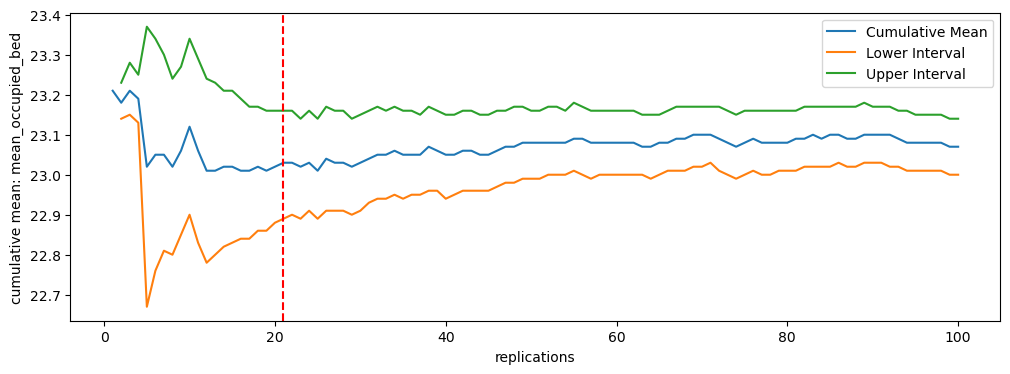

In [56]:
# plot the confidence intervals
ax = plot_confidence_interval_method(n_reps, conf_ints, 
                                     metric_name='mean_occupied_bed')

# ax.figure.savefig('fig1.png', dpi=300, bbox_inches='tight')


minimum number of reps for 5% precision: 21



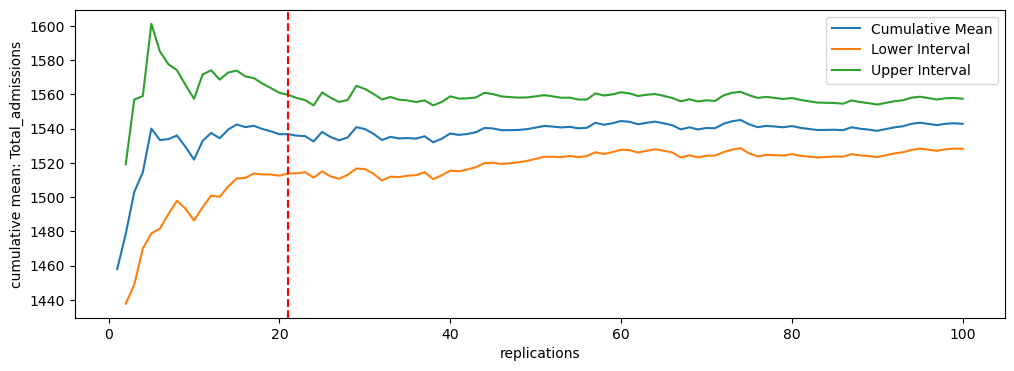

In [57]:
# run the method on the Total_admissions replications
n_reps, conf_ints = \
    confidence_interval_method(results['Total_admissions'].to_numpy(),
                               desired_precision=0.05)

# print out the min number of replications to achieve precision
print(f'\nminimum number of reps for 5% precision: {n_reps}\n')

# plot the confidence intervals
ax = plot_confidence_interval_method(n_reps, conf_ints, 
                                     metric_name='Total_admissions')

# ax.figure.savefig('fig2.png', dpi=300, bbox_inches='tight')


minimum number of reps for 5% precision: 22



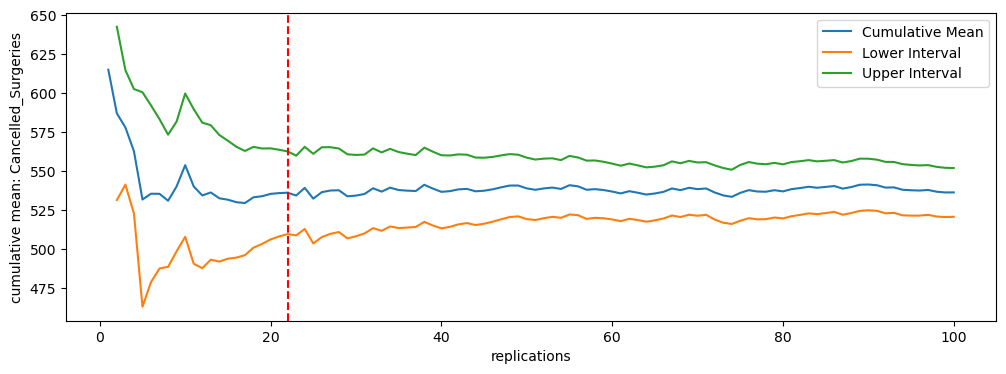

In [58]:
# run the method on the Cancelled_Surgeries replications
n_reps, conf_ints = \
    confidence_interval_method(results['Cancelled_Surgeries'].to_numpy(),
                               desired_precision=0.05)

# print out the min number of replications to achieve precision
print(f'\nminimum number of reps for 5% precision: {n_reps}\n')

# plot the confidence intervals
ax = plot_confidence_interval_method(n_reps, conf_ints, 
                                     metric_name='Cancelled_Surgeries')

# ax.figure.savefig('fig3.png', dpi=300, bbox_inches='tight')

Based on the results, we will set the replication number to 21.

# End